In [1]:
%load_ext autoreload
import ais_predict.trajpred.posgp as pgp
import ais_predict.datasets.bigquery as bq
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
plt.rcParams["figure.figsize"] = (14, 10)

<AxesSubplot:>

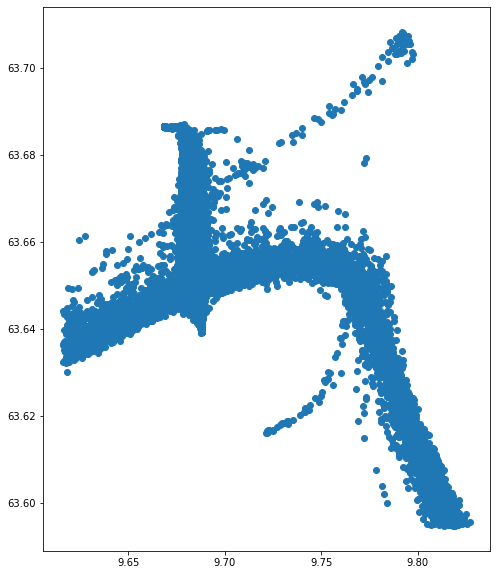

In [2]:
df = bq.download(limit=10000, lead=8)
df.position.plot()

<AxesSubplot:>

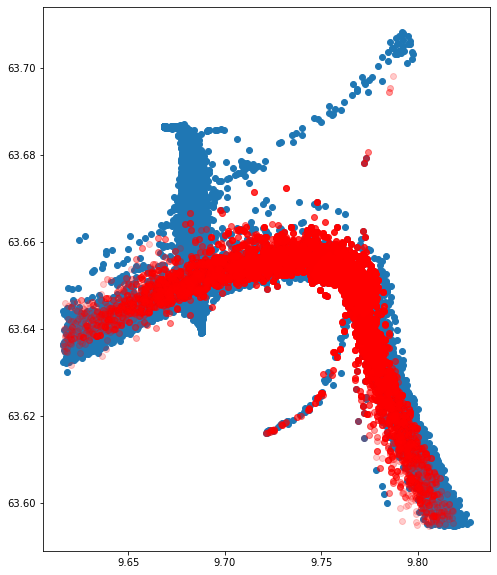

In [5]:
center = df.position.sample().to_crs(epsg=3857).to_numpy()[0]
subset = df.to_crs(epsg=3857).within(center.buffer(2e3))
ax = df.plot()
df[subset].plot(ax=ax, color="red")
df[subset].position_1.plot(ax=ax, color="red", alpha=0.9)
df[subset].position_2.plot(ax=ax, color="red", alpha=0.8)
df[subset].position_3.plot(ax=ax, color="red", alpha=0.7)
df[subset].position_4.plot(ax=ax, color="red", alpha=0.6)
df[subset].position_5.plot(ax=ax, color="red", alpha=0.5)
df[subset].position_6.plot(ax=ax, color="red", alpha=0.4)
df[subset].position_7.plot(ax=ax, color="red", alpha=0.3)
df[subset].position_8.plot(ax=ax, color="red", alpha=0.2)


In [6]:
%autoreload
within = gpd.GeoSeries(center.buffer(2e3), crs="epsg:3857").to_crs("wgs84").to_numpy()[0]
d = bq.download(lead=8, within=within, limit=10000, min_knots=5)

/home/haavard/.pyenv/versions/master-thesis/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


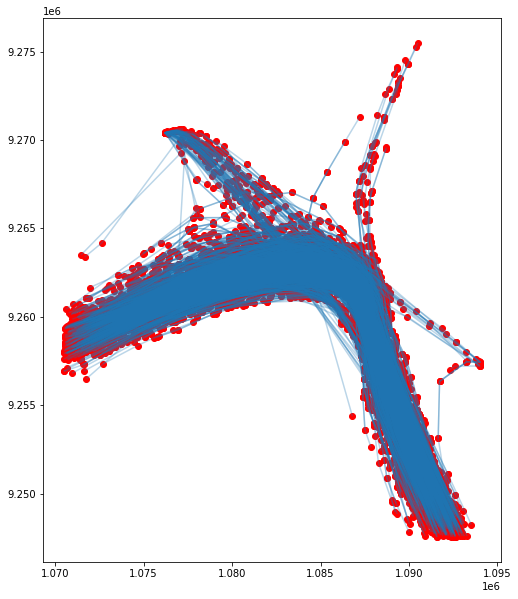

In [7]:
from shapely.geometry import Point, LineString
import geopandas as gpd
cols = d.columns.str.contains('position(_.*)?')
p = gpd.GeoSeries(d.loc[:, cols].apply(lambda x: LineString(x.tolist()), axis=1), crs="wgs84").to_crs(epsg=3857)
temp = gpd.GeoDataFrame({"lines": p, "cog": d.cog}, geometry="lines")
#print(d.loc[:, cols].dtypes)
ax = gpd.GeoSeries(d.loc[:, cols].melt().value, crs="wgs84").to_crs(epsg=3857).plot(color="red")
ax = temp.plot(ax=ax, alpha=0.3)

In [8]:
t = d.loc[(d.timestamp_1 - d.timestamp).dt.seconds < 10*60, :]
train_msk = np.random.rand(len(t)) < 0.5 
train = t[train_msk]
test = t[~train_msk]
train_x, train_y = pgp.samples_from_lag_n_df(train, n=8)
test_x, test_y = pgp.samples_from_lag_n_df(test, n=8)
msk = (test_x[:, -1] < 30*60)
test_x = test_x[msk, :]
test_y = test_y[msk, :]

In [16]:
%autoreload
m = pgp.PosGP(train_x, train_y, 10, log_per=1000)
f, std = m(test_x)
np.mean(abs(f - test_y), axis=0)

0 -2087012194.2681096
100 -1181594223.7304761
200 -841735477.5040853
300 -830232461.8594484
400 -687873095.1531764
500 -529023932.2175606
600 -491295951.3521413
700 -538569498.1745942
800 -390430566.17407936
900 -428750593.2463461
1000 -320767963.37087566
1100 -377312106.74613214
1200 -332200485.86153495
1300 -299770371.9982201
1400 -357646472.59692746
1500 -328371435.1556185
1600 -258754714.79465026
1700 -267877564.56378877
1800 -288017539.57923234
1900 -256804481.52157238
2000 -233981287.6566453
2100 -245195632.38521105
2200 -238395119.66253212
2300 -238368796.527948
2400 -259304679.26912907
2500 -203826828.87793037
2600 -227118465.7466846
2700 -210309996.2515447
2800 -211579088.7828876
2900 -172732899.1326084
3000 -183197887.42437616
3100 -228028811.65525454
3200 -202096529.2978339
3300 -171831796.777703
3400 -156366318.26768374
3500 -146563655.29896942
3600 -156770383.89638606
3700 -195566374.04498515
3800 -168918672.41298538
3900 -133474503.83977944
4000 -147246071.26589411
4100 -

array([3669.72131169, 2581.84720109])

In [10]:
from gpflow.utilities import print_summary
print_summary(m.gp)

╒════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                       │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                                │
╞════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.kernel.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 1014.1230513802668                                   │
├────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SVGP.kernel.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True   

(9249219.146925813, 9269868.063450066)

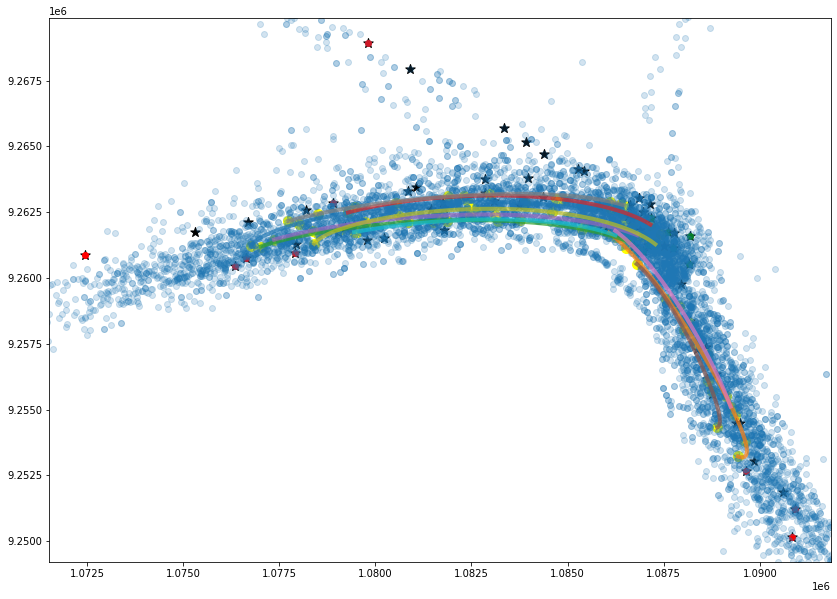

In [11]:
%autoreload
trials = 10
for i in range(trials):
    pX, pY = pgp.samples_from_lag_n_df(test.sample(), 8)
    msk = (pX[:, -1] < 20*60)
    pX = pX[msk, :]
    pY = pY[msk, :]
    t = np.linspace(pX[0, -1], pX[-1, -1], 100)
    X_pred = np.empty((len(t), pX.shape[-1]))
    X_pred[:, -1] = t
    X_pred[:, :-1] = pX[0, :-1]

    
    pred, var = m(X_pred)
    std = np.sqrt(np.linalg.norm(var))
    ci = 2*std


    y_pred, y_var= m(pX)
    plt.plot(*pred.T, alpha=0.7, linewidth=4)
    plt.scatter(*pY.T, color="black", marker="*", s=100)
    plt.scatter(*y_pred.T, color="yellow", marker="o", s=100)
    plt.scatter(*pY[0, :], color="g")
    plt.scatter(*pY[-1, :], color="r")
    #plt.plot(pred[:, 0], (pred[:, 1] + ci), color="black", alpha=0.4)
    #plt.plot(pred[:, 0], (pred[:, 1] - ci), color="black", alpha=0.4)
xlim = plt.xlim()
ylim = plt.ylim()
plt.scatter(*train_y.T, alpha=0.2)
plt.xlim(xlim)
plt.ylim(ylim)


[1041.80632583   90.94602963  104.36859225 ... 2173.85385587  581.74419649
  229.47346193]


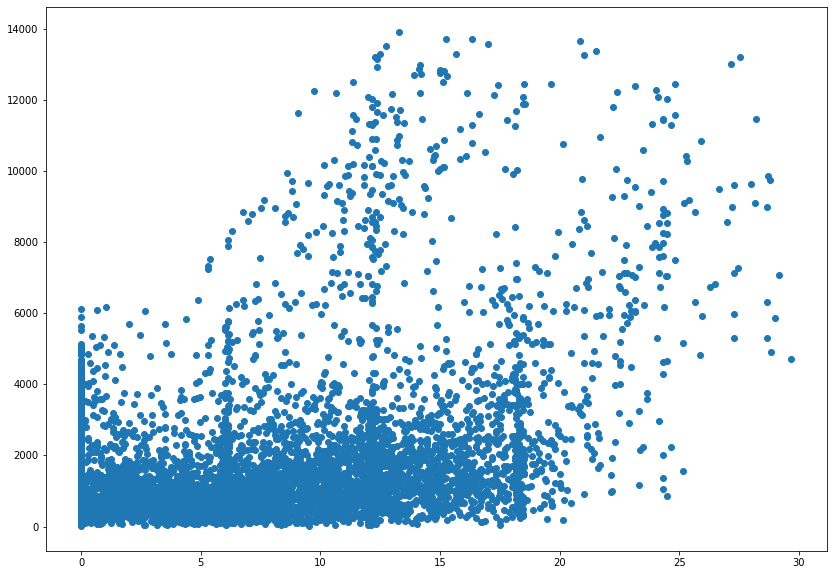

In [31]:
err = np.linalg.norm(f-test_y, axis=1)
print(err)
plt.scatter(test_x[:, -1] / 60, err)

In [32]:
std

1410.3531275655585

In [60]:

%autoreload
x = np.zeros((10, 5))
x[:, -1] = np.linspace(0, 15*60, 10)
m = pgp.PosGP(train_x, train_y, center=train_x[0, :2], N=1000)
kernel = m.kernel
K = kernel(m.gpx.data[0]).numpy()

plt.imshow(K)

InvalidArgumentError:  Input matrix is not invertible.
	 [[node triangular_solve/MatrixTriangularSolve (defined at /home/haavard/.pyenv/versions/master-thesis/lib/python3.9/site-packages/gpflow/logdensities.py:97) ]] [Op:__inference__tf_eval_166793]

Errors may have originated from an input operation.
Input Source operations connected to node triangular_solve/MatrixTriangularSolve:
 Cholesky (defined at /home/haavard/.pyenv/versions/master-thesis/lib/python3.9/site-packages/gpflow/models/gpr.py:87)	
 sub (defined at /home/haavard/.pyenv/versions/master-thesis/lib/python3.9/site-packages/gpflow/logdensities.py:96)

Function call stack:
_tf_eval
